# NLE Assignment: Sentiment Classification

In this assignment, you will be investigating NLP methods for distinguishing positive and negative reviews written about movies.

For assessment, you are expected to complete and submit this notebook file.  When answers require code, you may import and use library functions (unless explicitly told otherwise).  All of your own code should be included in the notebook rather than imported from elsewhere.  Written answers should also be included in the notebook.  You should insert as many extra cells as you want and change the type between code and markdown as appropriate.

In order to avoid misconduct, you should not talk about the assignment questions with your peers.  If you are not sure what a question is asking you to do or have any other questions, please ask me or one of the Teaching Assistants.

Marking guidelines are provided as a separate document.

The first few cells contain code to set-up the assignment and bring in some data.   In order to provide unique datasets for analysis by different students, you must enter your candidate number in the following cell.  Otherwise do not change the code in these cells.

In [ ]:
candidateno=249763 #this MUST be updated to your candidate number so that you get a unique data sample


In [ ]:
#do not change the code in this cell
#preliminary imports

#set up nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('movie_reviews')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import movie_reviews

#for setting up training and testing data
import random

#useful other tools
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import zip_longest
from nltk.probability import FreqDist
from nltk.classify.api import ClassifierI


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


In [ ]:
#do not change the code in this cell
def split_data(data, ratio=0.7): # when the second argument is not given, it defaults to 0.7
    """
    Given corpus generator and ratio:
     - partitions the corpus into training data and test data, where the proportion in train is ratio,

    :param data: A corpus generator.
    :param ratio: The proportion of training documents (default 0.7)
    :return: a pair (tuple) of lists where the first element of the 
            pair is a list of the training data and the second is a list of the test data.
    """
    
    data = list(data)  
    n = len(data)  
    train_indices = random.sample(range(n), int(n * ratio))          
    test_indices = list(set(range(n)) - set(train_indices))    
    train = [data[i] for i in train_indices]           
    test = [data[i] for i in test_indices]             
    return (train, test)                       
 

def get_train_test_data():
    
    #get ids of positive and negative movie reviews
    pos_review_ids=movie_reviews.fileids('pos')
    neg_review_ids=movie_reviews.fileids('neg')
   
    #split positive and negative data into training and testing sets
    pos_train_ids, pos_test_ids = split_data(pos_review_ids)
    neg_train_ids, neg_test_ids = split_data(neg_review_ids)
    #add labels to the data and concatenate
    training = [(movie_reviews.words(f),'pos') for f in pos_train_ids]+[(movie_reviews.words(f),'neg') for f in neg_train_ids]
    testing = [(movie_reviews.words(f),'pos') for f in pos_test_ids]+[(movie_reviews.words(f),'neg') for f in neg_test_ids]
   
    return training, testing

When you have run the cell below, your unique training and testing samples will be stored in `training_data` and `testing_data`

In [ ]:
#do not change the code in this cell
random.seed(249763)
training_data,testing_data=get_train_test_data()
print("The amount of training data is {}".format(len(training_data)))
print("The amount of testing data is {}".format(len(testing_data)))
print("The representation of a single data item is below")
print(training_data[0])

The amount of training data is 1400
The amount of testing data is 600
The representation of a single data item is below
(['perhaps', 'the', 'most', 'dramatic', 'changes', 'in', ...], 'pos')


1)  
a) **Generate** a list of 10 content words which are representative of the positive reviews in your training data.

b) **Generate** a list of 10 content words which are representative of the negative reviews in your training data.

c) **Explain** what you have done and why

[20\%]

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stopping = stopwords.words('english')

def list_norm(data, tag):
    if tag != '':
        words_normalisation = [([words for words in i[0] if words.isalpha() and words not in stopping], i[1]) for i in data if i[1] == tag]
        bag_of_words = [(FreqDist(i[0]), i[1]) for i in words_normalisation]
    else:
        words_normalisation = [([words for words in i[0] if words.isalpha() and words not in stopping], i[1]) for i in data]
        bag_of_words = [(FreqDist(i[0]), i[1]) for i in words_normalisation]
    return bag_of_words

def most_frequent_words(freq_dist_one, freq_dist_two, top_of_pos_or_neg):
    difference = freq_dist_one - freq_dist_two
    return list(dict(difference.most_common(top_of_pos_or_neg)).keys())

def freq_dist(data):
    my_freq_dist = FreqDist()
    for review, label in data:
        my_freq_dist += review
    return my_freq_dist

training_pos_freq = list_norm(training_data, "pos")
training_neg_freq = list_norm(training_data, "neg")

pos_freq_dist = freq_dist(training_pos_freq)
neg_freq_dist = freq_dist(training_neg_freq)

bag_of_training_pos = most_frequent_words(pos_freq_dist, neg_freq_dist, 10)
bag_of_training_neg = most_frequent_words(neg_freq_dist, pos_freq_dist, 10)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
print(bag_of_training_pos)

['film', 'life', 'also', 'well', 'best', 'great', 'world', 'films', 'many', 'story']


In [ ]:
print(bag_of_training_neg)

['bad', 'movie', 'plot', 'even', 'worst', 'stupid', 'like', 'could', 'nothing', 'boring']


When given a corpus, the computer sees a sequence of characters, reprensented as a sequence of binary numbers. This makes it difficult to efficiently search through a collection of documents which just characters. Therefore, for retrieval of documents we need to preprocess the documents in order for efficient search. This is why I first began my code by removing any stopwords, these are words in which are very common and don't carry a massive amount of information, they are ignored by the NLTK tokenisers. My next steps were about normalising the list given, this gets rid of punctuation marks and lowercasing all characters. All of this allows efficient search to be made on the collection of documents. I then created functions which make a frequency distribution of the data that has been split into postive and negative reviews. This is so we can use the frequency distribution to observe and calculate properties of the distribution, allowing us to make a decision. Finally, I created two different bag of words which have postive words in one and negative in the other, so I could print them.

2) 
a) **Use** the lists generated in Q1 to build a **word list classifier** which will classify reviews as being positive or negative.

b) **Explain** what you have done.

[12.5\%]


In [ ]:
from nltk.classify.api import ClassifierI

class WordsListClassifier(ClassifierI): 

    def __init__(self, pos, neg): 
        self._pos = pos 
        self._neg = neg 

    def classify(self, words): 
        score = 0
        for word, value in words.items():
            if word in self._pos:
                score +=value
            if word in self._neg:
                score -=value
        if score > 0:
            return 'pos'
        elif score == 0 or score < 0: 
          return 'neg'

    def labels(self): 
        return ("pos", "neg")

classifier = WordsListClassifier(bag_of_training_pos, bag_of_training_neg)
classifier.classify(FreqDist("terrible movie".split()))

'neg'

For this question I made my very own classifier, which takes words splits them and tries to work out whether they are positive words or negatives, the end result is a statement neg or pos for negative and positive. This is done by using the variable score, it takes away one everytime a negative word is detected or adds one if a positive word is detected. If the final score is positive the whole review is positive and if the final score is negative the whole review is negative. At the end I tried using a string to check if my classifier is working correctly.

3)
a) **Calculate** the accuracy, precision, recall and F1 score of your classifier.

b) Is it reasonable to evaluate the classifier in terms of its accuracy?  **Explain** your answer and give a counter-example (a scenario where it would / would not be reasonable to evaluate the classifier in terms of its accuracy).

[20\%]

In [ ]:
class ConfusionMatrix:
    def __init__(self,predictions,goldstandard,classes=("pos","neg"), display = True):
    
        (self.c1,self.c2)=classes
        self.TP=0
        self.FP=0
        self.FN=0
        self.TN=0
        for p,g in zip(predictions,goldstandard):
            if g==self.c1:
                if p==self.c1:
                    self.TP+=1
                else:
                    self.FN+=1
        
            elif p==self.c1:
                self.FP+=1
            else:
                self.TN+=1
        if display == True:
            print(f'True positive (tp) : {self.TP}\nFalse positive (fp) : {self.FP}\nTrue Negative (tn) : {self.TN}\nFalse negative (fn) : {self.FN}')
    
    def accuracy(self):
        self.acc = 0
        self.acc = (self.TP+self.TN)/(self.TP+self.FP+self.FN+self.TN)
        return self.acc
    
    def precision(self):
        self.p=0
        self.p = self.TP/(self.TP+self.FP)
        return self.p
  
    def recall(self):
        self.r=0
        self.r = self.TP/(self.TP+self.FN)
        return self.r
  
    def f1_score(self):
        self.f1=0
        self.f1 = 2*self.p*self.r/(self.p+self.r)
        return self.f1 

In [ ]:
testing_norm = list_norm(testing_data, '')
test_cases, labels = zip(*testing_norm)
myClassifer = WordsListClassifier(bag_of_training_pos, bag_of_training_neg)
prediction = myClassifer.classify_many(test_cases)
myClassifer = ConfusionMatrix(prediction, labels)

True positive (tp) : 223
False positive (fp) : 131
True Negative (tn) : 169
False negative (fn) : 77


In [ ]:
metrics_wordlist_classifier = {"Accuracy" : myClassifer.accuracy(), "Precision" :myClassifer.precision(), "Recall" : myClassifer.recall(), "F1Score" : myClassifer.f1_score()}
table = pd.DataFrame(metrics_wordlist_classifier, index = [0])
display(table)

,Accuracy,Precision,Recall,F1Score
0,0.653333,0.629944,0.743333,0.681957


Accuracy is a measurement for the proportion classified items in the data. However, it is not the best metric to fully evaluate a classifier.This is because accuracy does not work well with imbalanced data, this is data that has higher number of items on one argument and fewer in the other. For instance, if the number of positive reviews were to be 70% of the data and negative reviews 30% and the classifier fails to predict the negative reviews, it's accuracy would still be 70%, but that's not representing the whole data. In bigger scenarios, accuracy will not be a good choice of evaluating a classifier as there is a very low likelihood of a data set being split in perfect half. But in the case that somehow your data is split 50%, accuracy would be a great measure of evaluation, as it will show a true value for your data, allowing you to make better decisions based on the value.

4) 
a)  **Construct** a Naive Bayes classifier (e.g., from NLTK).

b)  **Compare** the performance of your word list classifier with the Naive Bayes classifier.  **Discuss** your results. 

[12.5\%]

In [ ]:
from nltk.classify import NaiveBayesClassifier
naive_training_data = list_norm(training_data, '')
naive_class_from_nltk = NaiveBayesClassifier.train(naive_training_data)
matrix_for_NB = ConfusionMatrix(naive_class_from_nltk.classify_many(test_cases), labels ,classes=('pos','neg'))
metrics_NB_classifier = {"Accuracy" : matrix_for_NB.accuracy(), "Precision" : matrix_for_NB.precision(), "Recall" : matrix_for_NB.recall(), "F1 score" : matrix_for_NB.f1_score()}
table2 = table.append(metrics_NB_classifier, True)

True positive (tp) : 294
False positive (fp) : 158
True Negative (tn) : 142
False negative (fn) : 6


In [ ]:
display(table2)

,Accuracy,Precision,Recall,F1Score,F1 score
0,0.653333,0.629944,0.743333,0.681957,NaN
1,0.726667,0.650442,0.980000,NaN,0.781915


There is a difference in the values of all atributes for both classifiers. The Naive Bayes Classifer seems to be the better classifier than my word classifier on unseen documents as it produced higher precision and recall values. The higher recall means that the Naive Bayes Classifier predicted correctly a greater number of +ve documents in proportion than my classifier or in other words less false negaties were detected by the NB Classifier. The precision value shows the proportion of +ve predictions that are correct, meaning less false positives were detected by the NB classifier, making it better than my classifier. The Accuracy and F1 score of NB classifier is also higher, these are clear values that NB's Classifier is better as the accuracy shows proportion of items classified correctly. The F1 score shows the harmonic mean between precision and recall, Since NB's classifier has higher precision and recall than my classifier we can automatically infer that the F1 score for NB's classifier is higher, making it the better performing classifier. 

5) 
a) Design and **carry out an experiment** into the impact of the **length of the wordlists** on the wordlist classifier.  Make sure you **describe** design decisions in your experiment, include a **graph** of your results and **discuss** your conclusions. 

b) Would you **recommend** a wordlist classifier or a Naive Bayes classifier for future work in this area?  **Justify** your answer.

[25\%]


In [ ]:
metrics = []
for i in range(1, 10, 100):
    bag_of_training_pos_ = most_frequent_words(pos_freq_dist, neg_freq_dist, i)
    bag_of_training_neg_ = most_frequent_words(neg_freq_dist, pos_freq_dist, i)
    bags_classified = WordsListClassifier(bag_of_training_pos_, bag_of_training_neg_)
    predic = bags_classified.classify_many(test_cases)
    graph = ConfusionMatrix(predic, labels, display = False)
    metrics.append([i, (graph.accuracy(), graph.precision(), graph.recall(), graph.f1_score())])

TypeError: ignored

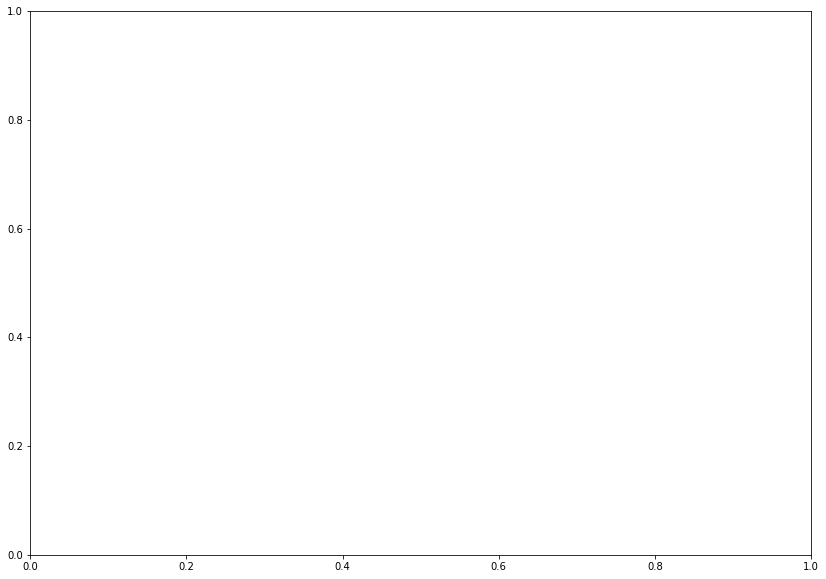

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (14, 10))
ax[1, 0].plot([i[0] for i in metrics], [i[1][0] for i in metrics], c = 'blue')
ax[1, 0].set_title('Impact of the length of the wordlists on the wordlist classifier')
ax[1, 0].set(ylabel = 'Accuracy' ,xlabel = 'Length of Wordlist')
ax[1, 0].set(ylabel = 'Precision' ,xlabel = 'Length of Wordlist')
ax[1, 0].set(ylabel = 'Recall' ,xlabel = 'Length of Wordlist')
ax[1, 0].set(ylabel = 'F1Score' ,xlabel = 'Length of Wordlist')

In [ ]:
plt.show()

Both Classifiers have their disadvantages and advantages. The wordlist classifier, does its job of classifying the data in a document, but it does not do it as accurately as Naive Bayes Classifier. The better the accuracy the better the decision making, however, as previously explored it is not a good metric to evaluate on a classifier due to imbalances in the data. A disadvantage of the NB classifier is that it assumes that all features are independent, which is not always the case in the real world, this makes it harder to use if there are some set of independent events. This can be disregarded as the other metric values that NB's classifier produces come with a lot of importance. It provides higher precision and recall values, making the overall F1 score higher, This allows me to make better decisions. Although I do not have a valid experiment to explain the impact of length of word lists for the word list classifier, I have learnt that, the accuracy, precision, recall and F1 score of the classifier would get lower over the length of wordlists increases, as data set increases, there is a higher chance of getting false postives and negatives not predicted. On the other hand, NB's classifier would perform better as there is less of an impact if the data set increases. In conclusion, I would be using a NB Classifier when working in this area in the future, as this classifier performs better.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
##This code will word count all of the markdown cells in the notebook saved at filepath
##Running it before providing any answers shows that the questions have a word count of 437

import io
from nbformat import current

filepath="/content/drive/My Drive/NLassignment2022.ipynb"
#filepath="NLassignment2021.ipynb"
question_count=437

with io.open(filepath, 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print("Submission length is {}".format(word_count-question_count))

Submission length is 863
